***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.1)** 32D>16D>8D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = 30BFPC1AXW95
• Working Directory = C:\Users\knoor\OneDrive - Deakin University\Deep Learning with Python\Google_Drive\Projects\Deep Learning\HD-CapsNet\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : py38tf


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('3_CIFAR_10/HD_CapsNet/Mod_4_1_1')

# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    y_proba = tf.math.divide(y_proba,tf.reshape(tf.reduce_sum(y_proba,-1),(-1,1),name='reshape'),name='Normalising_Probability')
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,C_Weight=0.2):
    # getting the loss for each level
    loss_coarse = margin_loss(y_true_c, y_pred_c)
    loss_medium = margin_loss(y_true_m, y_pred_m)
    loss_fine = margin_loss(y_true_f, y_pred_f)

    # Check for consistency between levels using Bayes' theorem
    # Convert predicted probabilities to log probabilities for numerical stability
    # coarse_predictions = 1.0-tf.reduce_sum(y_true_c*y_pred_c, axis=1)
    # medium_predictions = 1.0-tf.reduce_sum(y_true_m*y_pred_m, axis=1)
    # fine_predictions = 1.0-tf.reduce_sum(y_true_f*y_pred_f, axis=1)
    prob_coarse = 1.0-loss_coarse
    prob_medium = 1.0-loss_medium
    prob_fine = 1.0-loss_fine
    
    log_pred_coarse = tf.math.log(tf.clip_by_value(prob_coarse, 1e-10, 1.0))
    log_pred_medium = tf.math.log(tf.clip_by_value(prob_medium, 1e-10, 1.0))
    log_pred_fine = tf.math.log(tf.clip_by_value(prob_fine, 1e-10, 1.0))

    prob_fine_to_medium = tf.reduce_sum(-(log_pred_fine-log_pred_medium))
    prob_medium_to_coarse = tf.reduce_sum(-(log_pred_medium-log_pred_coarse))
    
    batch_loss = LW_C*loss_coarse + LW_M*prob_medium_to_coarse + LW_F*prob_fine_to_medium

    return tf.reduce_mean(batch_loss)

In [10]:
-(tf.math.log(tf.clip_by_value(0.4, 1e-10, 1.0))-tf.math.log(tf.clip_by_value(0.9, 1e-10, 1.0)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.81093013>

In [11]:
tf.math.log(tf.clip_by_value(0.4, 1e-10, 1.0))

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9162907>

## Model Architecture

In [12]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 8

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims), 
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Skip Connection: For Medium Level
    p_caps_m = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_c.shape[-1]),
                                     s_caps_c.shape[-1]), name="primary_skip_m")(p_caps)
    skip_m = keras.layers.Concatenate(axis=1)([p_caps_m, s_caps_c])

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(skip_m)
    
    ## Skip Connection: For Fine Level
    p_caps_f = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_m.shape[-1]),
                                     s_caps_m.shape[-1]), name="primary_skip_f")(p_caps)
    skip_f = keras.layers.Concatenate(axis=1)([p_caps_f, s_caps_m])

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(skip_f)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']
                              )
                    )

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [13]:
model = get_compiled_model()

In [14]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 7)           0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 10)           0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['prediction_coarse[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.reduce_sum_2 (TFOpLamb  (None,)             0           ['prediction_medium[0][0]']      
 da)      

                                                                  'tf.math.square[0][0]']         
                                                                                                  
 tf.math.multiply_2 (TFOpLambda  (None, 2)           0           ['tf.math.multiply_1[0][0]',     
 )                                                                'tf.math.square_1[0][0]']       
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None, 7)           0           ['input_ym[0][0]',               
 )                                                                'tf.math.square_2[0][0]']       
                                                                                                  
 tf.math.multiply_5 (TFOpLambda  (None, 7)           0           ['tf.math.multiply_4[0][0]',     
 )                                                                'tf.math.square_3[0][0]']       
          

 a)                                                                                               
                                                                                                  
 tf.math.reduce_sum_6 (TFOpLamb  ()                  0           ['tf.math.negative[0][0]']       
 da)                                                                                              
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None,)             0           ['tf.math.multiply_9[0][0]',     
 da)                                                              'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  ()                  0           ['tf.math.reduce_sum_6[0][0]']   
 a)                                                                                               
          

## Data Augmentation

In [15]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [16]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [17]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 7.4768 - prediction_coarse_accuracy: 0.1277 - prediction_medium_accuracy: 0.4680 - prediction_fine_accuracy: 0.4347
  • Coarse Accuracy = 12.77% | Val_Accuracy = 12.42% | LossWeight = 0.56 
  • Medium Accuracy = 46.80% | Val_Accuracy = 52.18% | LossWeight = 0.24 
  • Fine   Accuracy = 43.47% | Val_Accuracy = 48.18% | LossWeight = 0.19 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.48180, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_4_1_1\epoch-best.h5
781/781 [==============================] - 46s 50ms/step - loss: 7.4768 - prediction_coarse_accuracy: 0.1277 - prediction_medium_accuracy: 0.4680 - prediction_fine_accuracy: 0.4347 - val_loss: 3.4053 - val_prediction_coarse_accuracy: 0.1242 - val_prediction_medium_accuracy: 0.5218 - val_prediction_fine_accuracy: 0.4818 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 5.2287 - prediction_coarse_accuracy: 0.3820

781/781 [==============================] - 35s 45ms/step - loss: -235.2312 - prediction_coarse_accuracy: 0.3911 - prediction_medium_accuracy: 0.4347 - prediction_fine_accuracy: 0.3062 - val_loss: -129.9411 - val_prediction_coarse_accuracy: 0.3952 - val_prediction_medium_accuracy: 0.4712 - val_prediction_fine_accuracy: 0.3599 - lr: 0.0010
Epoch 11/100
781/781 [==============================] - ETA: 0s - loss: -236.4083 - prediction_coarse_accuracy: 0.3957 - prediction_medium_accuracy: 0.4597 - prediction_fine_accuracy: 0.3381
  • Coarse Accuracy = 39.57% | Val_Accuracy = 38.98% | LossWeight = 0.45 
  • Medium Accuracy = 45.97% | Val_Accuracy = 50.93% | LossWeight = 0.29 
  • Fine   Accuracy = 33.81% | Val_Accuracy = 38.39% | LossWeight = 0.26 

Epoch 11: val_prediction_fine_accuracy did not improve from 0.68010
781/781 [==============================] - 37s 47ms/step - loss: -236.4083 - prediction_coarse_accuracy: 0.3957 - prediction_medium_accuracy: 0.4597 - prediction_fine_accuracy: 0

781/781 [==============================] - 34s 43ms/step - loss: -243.4626 - prediction_coarse_accuracy: 0.3899 - prediction_medium_accuracy: 0.6481 - prediction_fine_accuracy: 0.5493 - val_loss: -133.4377 - val_prediction_coarse_accuracy: 0.3567 - val_prediction_medium_accuracy: 0.6814 - val_prediction_fine_accuracy: 0.5846 - lr: 3.7735e-04
Epoch 30/100
781/781 [==============================] - ETA: 0s - loss: -244.0025 - prediction_coarse_accuracy: 0.3729 - prediction_medium_accuracy: 0.6760 - prediction_fine_accuracy: 0.5743
  • Coarse Accuracy = 37.29% | Val_Accuracy = 33.23% | LossWeight = 0.58 
  • Medium Accuracy = 67.60% | Val_Accuracy = 68.97% | LossWeight = 0.21 
  • Fine   Accuracy = 57.43% | Val_Accuracy = 60.13% | LossWeight = 0.21 

Epoch 30: val_prediction_fine_accuracy did not improve from 0.68010
781/781 [==============================] - 36s 46ms/step - loss: -244.0025 - prediction_coarse_accuracy: 0.3729 - prediction_medium_accuracy: 0.6760 - prediction_fine_accurac

781/781 [==============================] - 38s 49ms/step - loss: -246.0552 - prediction_coarse_accuracy: 0.2986 - prediction_medium_accuracy: 0.7453 - prediction_fine_accuracy: 0.6686 - val_loss: -134.4541 - val_prediction_coarse_accuracy: 0.2381 - val_prediction_medium_accuracy: 0.7525 - val_prediction_fine_accuracy: 0.6842 - lr: 1.4240e-04
Epoch 49/100
781/781 [==============================] - ETA: 0s - loss: -247.0593 - prediction_coarse_accuracy: 0.2743 - prediction_medium_accuracy: 0.7419 - prediction_fine_accuracy: 0.6654
  • Coarse Accuracy = 27.43% | Val_Accuracy = 16.64% | LossWeight = 0.67 
  • Medium Accuracy = 74.19% | Val_Accuracy = 71.18% | LossWeight = 0.17 
  • Fine   Accuracy = 66.54% | Val_Accuracy = 64.69% | LossWeight = 0.16 

Epoch 49: val_prediction_fine_accuracy did not improve from 0.68420
781/781 [==============================] - 36s 46ms/step - loss: -247.0593 - prediction_coarse_accuracy: 0.2743 - prediction_medium_accuracy: 0.7419 - prediction_fine_accurac

781/781 [==============================] - 36s 46ms/step - loss: -249.0225 - prediction_coarse_accuracy: 0.2831 - prediction_medium_accuracy: 0.7233 - prediction_fine_accuracy: 0.6453 - val_loss: -137.0775 - val_prediction_coarse_accuracy: 0.2307 - val_prediction_medium_accuracy: 0.7388 - val_prediction_fine_accuracy: 0.6705 - lr: 5.3734e-05
Epoch 68/100
781/781 [==============================] - ETA: 0s - loss: -249.2338 - prediction_coarse_accuracy: 0.2697 - prediction_medium_accuracy: 0.7281 - prediction_fine_accuracy: 0.6509
  • Coarse Accuracy = 26.97% | Val_Accuracy = 23.12% | LossWeight = 0.66 
  • Medium Accuracy = 72.81% | Val_Accuracy = 73.75% | LossWeight = 0.17 
  • Fine   Accuracy = 65.09% | Val_Accuracy = 66.54% | LossWeight = 0.17 

Epoch 68: val_prediction_fine_accuracy did not improve from 0.68420
781/781 [==============================] - 35s 45ms/step - loss: -249.2338 - prediction_coarse_accuracy: 0.2697 - prediction_medium_accuracy: 0.7281 - prediction_fine_accurac

781/781 [==============================] - 37s 47ms/step - loss: -257.2209 - prediction_coarse_accuracy: 0.2278 - prediction_medium_accuracy: 0.7302 - prediction_fine_accuracy: 0.6537 - val_loss: -141.8400 - val_prediction_coarse_accuracy: 0.1519 - val_prediction_medium_accuracy: 0.7402 - val_prediction_fine_accuracy: 0.6741 - lr: 2.0277e-05
Epoch 87/100
780/781 [============================>.] - ETA: 0s - loss: -258.7580 - prediction_coarse_accuracy: 0.2244 - prediction_medium_accuracy: 0.7317 - prediction_fine_accuracy: 0.6542
  • Coarse Accuracy = 22.44% | Val_Accuracy = 15.30% | LossWeight = 0.68 
  • Medium Accuracy = 73.17% | Val_Accuracy = 74.08% | LossWeight = 0.16 
  • Fine   Accuracy = 65.42% | Val_Accuracy = 67.45% | LossWeight = 0.16 

Epoch 87: val_prediction_fine_accuracy did not improve from 0.68420
781/781 [==============================] - 37s 47ms/step - loss: -258.7488 - prediction_coarse_accuracy: 0.2244 - prediction_medium_accuracy: 0.7317 - prediction_fine_accurac

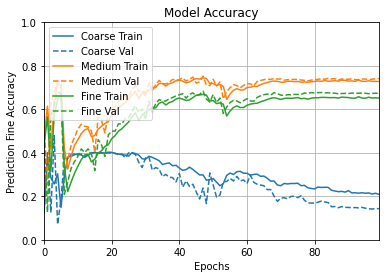

In [18]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

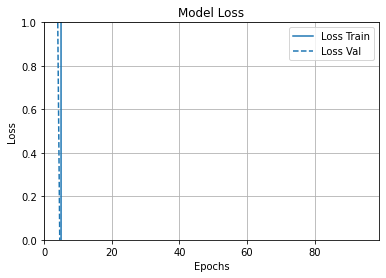

In [19]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [20]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 7s 19ms/step - loss: 0.7663 - prediction_coarse_loss: 0.9057 - prediction_medium_loss: 0.3602 - prediction_fine_loss: 0.5912 - prediction_coarse_accuracy: 0.1431 - prediction_medium_accuracy: 0.7413 - prediction_fine_accuracy: 0.6738
1. loss ==> 0.7663263082504272
2. prediction_coarse_loss ==> 0.9057372808456421
3. prediction_medium_loss ==> 0.36016175150871277
4. prediction_fine_loss ==> 0.5912207961082458
5. prediction_coarse_accuracy ==> 0.14309999346733093
6. prediction_medium_accuracy ==> 0.7412999868392944
7. prediction_fine_accuracy ==> 0.673799991607666
313/313 [==============================] - 4s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

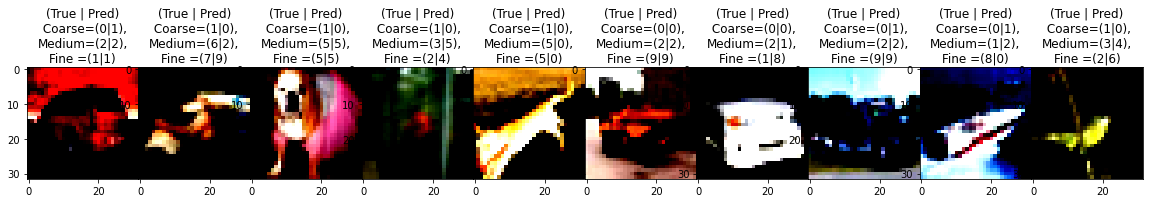

In [21]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[1376 2624]
 [5945   55]]

  • MEDIUM LEVEL 
[[ 694   56  177   22    7   15   29]
 [  67  637  259    1    4   16   16]
 [  36   16 1900    4   16   14   14]
 [ 103   12   38  449  115  156  127]
 [   9    5   28   22  849   61   26]
 [  34   27  133   61  140 1378  227]
 [  42   12   74   48  151  167 1506]]

  • FINE LEVEL 
[[749  53  29   9   9   5   9   9  73  55]
 [ 24 826   1   3   1   1   9   1  21 113]
 [101   9 489  64  93  56 115  36  12  25]
 [ 24  24  45 408  42 191 117  64  27  58]
 [ 29  13  36  43 528  33 135 160   9  14]
 [ 14   9  32 152  42 586  38  88  10  29]
 [ 10   8  23  39  17  16 858   9   4  16]
 [ 20   5  12  25  38  45  13 796   4  42]
 [ 95  74   4  11   2   3   4   9 751  47]
 [ 35 153   4  12   5   2  10   9  23 747]]

  • Classification Report 


  • COARSE LEVEL 


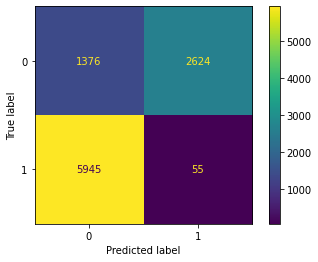

              precision    recall  f1-score   support

           0    0.18795   0.34400   0.24309      4000
           1    0.02053   0.00917   0.01267      6000

    accuracy                        0.14310     10000
   macro avg    0.10424   0.17658   0.12788     10000
weighted avg    0.08750   0.14310   0.10484     10000


  • MEDIUM LEVEL 


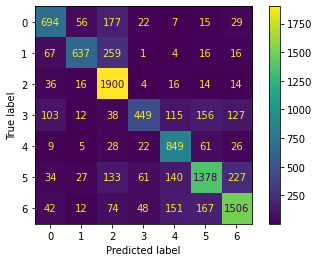

              precision    recall  f1-score   support

           0    0.70457   0.69400   0.69924      1000
           1    0.83268   0.63700   0.72181      1000
           2    0.72825   0.95000   0.82447      2000
           3    0.73970   0.44900   0.55881      1000
           4    0.66225   0.84900   0.74408      1000
           5    0.76259   0.68900   0.72393      2000
           6    0.77429   0.75300   0.76350      2000

    accuracy                        0.74130     10000
   macro avg    0.74348   0.71729   0.71941     10000
weighted avg    0.74695   0.74130   0.73477     10000


  • FINE LEVEL 


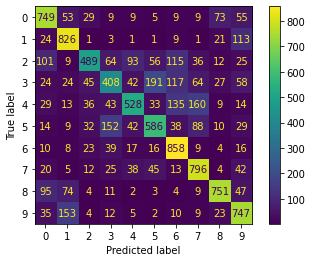

              precision    recall  f1-score   support

           0    0.68029   0.74900   0.71299      1000
           1    0.70358   0.82600   0.75989      1000
           2    0.72444   0.48900   0.58388      1000
           3    0.53264   0.40800   0.46206      1000
           4    0.67954   0.52800   0.59426      1000
           5    0.62473   0.58600   0.60475      1000
           6    0.65596   0.85800   0.74350      1000
           7    0.67401   0.79600   0.72994      1000
           8    0.80407   0.75100   0.77663      1000
           9    0.65183   0.74700   0.69618      1000

    accuracy                        0.67380     10000
   macro avg    0.67311   0.67380   0.66641     10000
weighted avg    0.67311   0.67380   0.66641     10000



In [22]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [23]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.62069 
Hierarchical Recall = 0.8031333333333333 
Hierarchical F1-Score = 0.6977428571428572 
Consistency =  0.1566 
Exact Match =  0.096
